# Ch6. TD법 
> TD법 : 'Temporal Difference'의 약자로 '시간차'라는 뜻. 에피소드가 끝날때까지 기다리지 않고 일정 시간마다 정책을 평가하고 개선함 (DP와 MC를 합쳐서 보완한 형태)
-  배운내용을 복습 : 몬테카를로법(이하 MC법), 동적프로그램법(TD법)


## 6.1 TD법으로 정책 평가하기
> '수익'에 대해 복습해보자.<br>

![](./images/eq_06_01.png)<br>
- 시간t부터 시작하여 보상이 $R_t, R_{t+1}$...식으로 주어진다면 수식은 할인률을 적용한 보상의 합으로 표현

> MC법 이용 기법 <식 6.3>과 DP법 이용 기법 <식 6.4>

![](./images/eq_06_03.png)<br>

- $v_{\pi}(s)$: 가치함수, $G_t$ : t 상태에서의 수익으로,

> MC법 이용 기법

![](./images/eq_06_05.png)<br>
- MC법에서는 기댓값을 계산하는 대신 실제 수익의 샘플 데이터를 평균하여 식 6.3의  기댓값을 근사.
    - 지수이동평균 이용시 수익발생시마다 $\alpha$로 갱신    

>  DP법 이용기법

![](./images/eq_06_04.png)<br>
- <식 6-4>와 같이 DP법에서는  기댓값을 구함 <br>
- <식 6-6> 은 벨만 방정식으로 DP법은 벨만 방정식을 기반으로 가치함수를 순차적으로 갱신
> 벨만 방정식 : 정책, 상태전이확률, 보상함수를 알면 연립방정식을 풀이 가능

![](./images/fig_06_01.png)<br>

> TD법 아이디어 
- DP 법처럼 부트스트랩을 통해 가치함수를 순차적으로 갱신
- MC법처럼 환경에 대한 정보 없이 샘플링된 데이터만으로 가치함수 갱신
![](./images/eq_06_06.png)
- [식 6-6] 벨만방정식은 모든 후보에 대해 보상과 다음 가치함수를 계산하는 과정에서, 
- 보상과 다음가치함수 부분을 샘플데이터에서 근사, 따라서 TD법의 갱신식은 [식 6-9]와 같음 <br>
![](./images/eq_06_09.png)<br>
![](./images/fig_06_02.png)<br>


### 6.1.1 MC법과 TD법 비교

- MC 법의 목표는 오랜 시간 쌓였기에 분산이 크지만 TD법은 한단계의 시간마다 갱신되어 분산 적음
- 단, TD법은 추정치로 추정치를 갱신하는 '부트스트래핑'이기에 편향이 있지만, 갱신 반복시마다 편향은 작아지며 0으로 수렴

![](./images/fig_06_04.png)<br>


![](./images/fig_06_03.png)<br>
> MC법은 $G_t$를 목표로 하여 그 방향으로 $V_{pi}$ 갱신하는 반면 TD법은 한단계 앞의 정보를 적용하여 계산
    - $G_t$ : 목표에 도달했을 때 얻을 수 있는 수익의 샘플데이터

### 6.1.2 TD법 구현

In [1]:
from collections import defaultdict  # 기본값을 가지는 딕셔너리를 사용하기 위한 모듈 임포트
import numpy as np  
from dezerogym.gridworld import GridWorld  # GridWorld 환경을 사용하기 위한 모듈 임포트

class TdAgent:
    def __init__(self):
        self.gamma = 0.9  # 할인율 설정
        self.alpha = 0.01  # 학습률 설정
        self.action_size = 4  # 가능한 행동의 개수 설정

        # 초기 정책을 무작위로 설정
        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)  # 정책 딕셔너리 초기화
        self.V = defaultdict(lambda: 0)  # 상태 가치 함수 딕셔너리 초기화

    def get_action(self, state):
        action_probs = self.pi[state]  # 현재 상태에서의 행동 확률 가져오기
        actions = list(action_probs.keys())  # 가능한 행동 리스트 생성
        probs = list(action_probs.values())  # 행동 확률 리스트 생성
        return np.random.choice(actions, p=probs)  # 행동 확률에 따라 행동 선택

    def eval(self, state, reward, next_state, done):
        next_V = 0 if done else self.V[next_state]  # 다음 상태의 가치 함수 값 계산
        target = reward + self.gamma * next_V  # TD 타겟 계산
        self.V[state] += (target - self.V[state]) * self.alpha  # 상태 가치 함수 업데이트

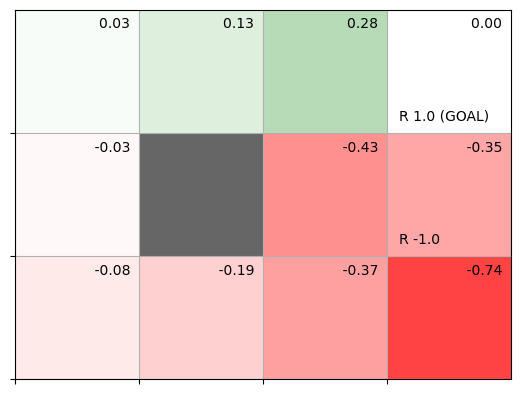

In [2]:
env = GridWorld()  # GridWorld 환경 인스턴스 생성
agent = TdAgent()  # TD 에이전트 인스턴스 생성

episodes = 1000  # 총 에피소드 수 설정
for episode in range(episodes):  # 에피소드 반복
    state = env.reset()  # 환경 초기화 및 초기 상태 받기

    while True:  # 에피소드 내에서 반복
        action = agent.get_action(state)  # 현재 상태에서 행동 선택
        next_state, reward, done = env.step(action)  # 행동 수행 및 다음 상태, 보상, 종료 여부 받기

        agent.eval(state, reward, next_state, done)  # TD 업데이트 수행
        if done:  # 종료 상태이면 반복 종료
            break
        state = next_state  # 다음 상태로 업데이트

env.render_v(agent.V)  # 학습된 상태 가치 함수 시각화

## 6.2 SARSA
- 평가와 개선을 반복하며 최적정책에 가까워지도록 제어
- 개선단계에서는 정책을 탐욕화 해야하며, $V_{\pi}$의 경우 환경모델이 필요, $Q_{\pi}(s,a)$라면 다음과 같이 계산
- $\mu(s)=argmaxQ_{\pi}(s,a)$ 
- 기존 상태가치함수로 표현된 TD공식을 Q함수로 바꾸면 <br>
![](./images/eq_06_09.png)<br>
▼<br>
![](./images/eq_06_10.png)<br>
![](./images/fig_06_06.png)<br>
![](./images/eq_06_11.png)
- Q함수는 상태와 행동을 묶은 데이터를 하나의 단위로 삼음
- 평가 과정 : [그림 6-6]과 같은 하나의 셋을 얻었다면 [식 6-10]에 대입하여 $Q_{\pi}(S_t,A_t)$가 갱신
- 개선 과정 : [식 6-11] 과 같이 $\epsilon$의 확률로 무작위 행동을 선택하고, 그 외에는 탐욕행동을 선택하며, 탐색을 실행하는 동시에 정책을 개선함

> 평가와 개선 과정을 번갈아 반복하면서 최적에 가까운 정책을 찾는 알고리즘이 Salsa


### 6.2.1 온-정책 SARSA
- 온정책에서 에이전트는 정책하나만 보유 : 행동정책과 대상정책 동일 
    - 행동정책 : 실제로 행동을 선택하는 정책
    - 대상정책 : 평가 및 개선하는 정책

In [4]:
def argmax(xs):
    """
    리스트 xs에서 최대값을 가지는 인덱스를 반환합니다.
    최대값이 여러 개인 경우 무작위로 하나의 인덱스를 선택합니다.
    """
    idxes = [i for i, x in enumerate(xs) if x == max(xs)]  # 최대값을 가지는 인덱스 리스트
    if len(idxes) == 1:  # 최대값이 유일한 경우
        return idxes[0]
    elif len(idxes) == 0:  # 리스트가 비어있는 경우
        return np.random.choice(len(xs))  # 무작위로 인덱스 선택
    selected = np.random.choice(idxes)  # 최대값 인덱스 중 하나 선택
    return selected

def greedy_probs(Q, state, epsilon=0, action_size=4):
    """
    epsilon-greedy 정책에 따른 행동 확률 분포를 계산합니다.
    Q: 상태-행동 가치 함수
    state: 현재 상태
    epsilon: 무작위 행동 선택 확률
    action_size: 가능한 행동의 개수
    """
    qs = [Q[(state, action)] for action in range(action_size)]  # 현재 상태에서의 행동 가치
    max_action = argmax(qs)  # 최대 가치를 가지는 행동 인덱스
    base_prob = epsilon / action_size  # 무작위 행동 선택 확률
    action_probs = {action: base_prob for action in range(action_size)}  # 초기 행동 확률 분포
    action_probs[max_action] += (1 - epsilon)  # 최대 가치 행동 확률 업데이트
    return action_probs

### 6.2.2 SARSA구현

In [5]:
from collections import deque  # 메모리를 구현하기 위해 deque 모듈 임포트

class SarsaAgent:
    def __init__(self):
        self.gamma = 0.9  # 할인율 설정
        self.alpha = 0.8  # 학습률 설정
        self.epsilon = 0.1  # 무작위 행동 선택 확률 설정
        self.action_size = 4  # 가능한 행동의 개수 설정

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}  # 초기 정책을 무작위로 설정
        self.pi = defaultdict(lambda: random_actions)  # 정책 딕셔너리 초기화
        self.Q = defaultdict(lambda: 0)  # 상태-행동 가치 함수 딕셔너리 초기화
        self.memory = deque(maxlen=2)  # 메모리 초기화 (최대 길이 2)

    def get_action(self, state):
        action_probs = self.pi[state]  # 현재 상태에서의 행동 확률 가져오기
        actions = list(action_probs.keys())  # 가능한 행동 리스트 생성
        probs = list(action_probs.values())  # 행동 확률 리스트 생성
        return np.random.choice(actions, p=probs)  # 행동 확률에 따라 행동 선택

    def reset(self):
        self.memory.clear()  # 메모리 초기화

    def update(self, state, action, reward, done):
        self.memory.append((state, action, reward, done))  # 메모리에 경험 저장
        if len(self.memory) < 2:  # 메모리의 길이가 2 미만이면 업데이트 불가능
            return

        state, action, reward, done = self.memory[0]  # 이전 경험 가져오기
        next_state, next_action, _, _ = self.memory[1]  # 현재 경험 가져오기
        next_q = 0 if done else self.Q[next_state, next_action]  # 다음 상태-행동 가치 계산

        target = reward + self.gamma * next_q  # SARSA 타겟 계산
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha  # 상태-행동 가치 함수 업데이트
        self.pi[state] = greedy_probs(self.Q, state, self.epsilon)  # 정책 업데이트

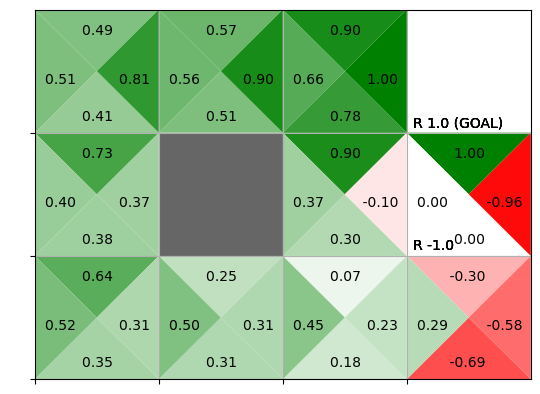

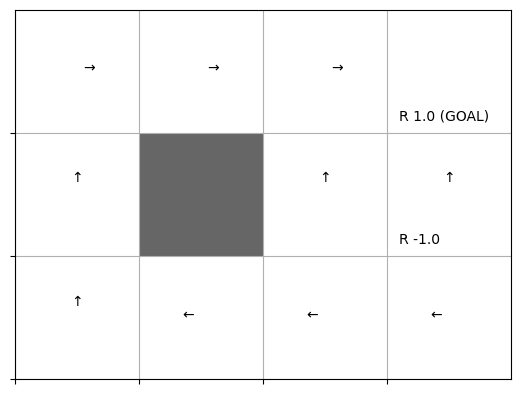

In [8]:
env = GridWorld()  # GridWorld 환경 인스턴스 생성
agent = SarsaAgent()  # SARSA 에이전트 인스턴스 생성

episodes = 10000  # 총 에피소드 수 설정
for episode in range(episodes):  # 에피소드 반복
    state = env.reset()  # 환경 초기화 및 초기 상태 받기
    agent.reset()  # 에이전트 메모리 초기화

    while True:  # 에피소드 내에서 반복
        action = agent.get_action(state)  # 현재 상태에서 행동 선택
        next_state, reward, done = env.step(action)  # 행동 수행 및 다음 상태, 보상, 종료 여부 받기

        agent.update(state, action, reward, done)  # SARSA 업데이트 수행

        if done:  # 종료 상태이면
            agent.update(next_state, None, None, None)  # 마지막 업데이트 수행
            break
        state = next_state  # 다음 상태로 업데이트

env.render_q(agent.Q)  # 학습된 상태-행동 가치 함수 시각화

## 6.3 오프정책 SARSA

In [14]:
class SarsaOffPolicyAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = deque(maxlen=2)

    def get_action(self, state):
        action_probs = self.b[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def reset(self):
        self.memory.clear()

    def update(self, state, action, reward, done):
        self.memory.append((state, action, reward, done))
        if len(self.memory) < 2:
            return

        state, action, reward, done = self.memory[0]
        next_state, next_action, _, _ = self.memory[1]

        if done:
            next_q = 0
            rho = 1
        else:
            next_q = self.Q[next_state, next_action]
            rho = self.pi[next_state][next_action] / self.b[next_state][next_action]

        target = rho * (reward + self.gamma * next_q)
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha

        self.pi[state] = greedy_probs(self.Q, state, 0)
        self.b[state] = greedy_probs(self.Q, state, self.epsilon)

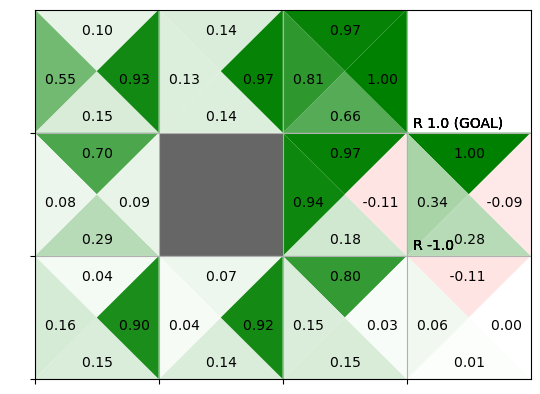

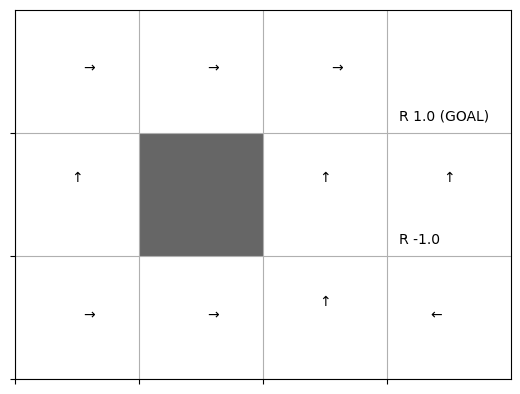

In [15]:
env = GridWorld()
agent = SarsaOffPolicyAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, done)

        if done:
            agent.update(next_state, None, None, None)
            break
        state = next_state

env.render_q(agent.Q)

## 6.4 Q러닝

- 오프정책 방식에서는 행동정책, 대상정책을 가지고 있었을 탐색 활용
- 단점 : 중요도 샘플링 해야함.
- 특히 두 확률분포가 다를 수록 중요도 샘플링에서 가중치 변동성이 커짐, 그러면 갱신식의 목표가 불안정해져서 Q함수 갱신 불안정 
- Q러닝은 TD법으로 오프정책을 쓰지만 중요도샘플링은하지않음.

In [16]:
'''
ch06/q_learning.py
'''
class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)

    def get_action(self, state):
        action_probs = self.b[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def update(self, state, action, reward, next_state, done):
        if done:
            next_q_max = 0
        else:
            next_qs = [self.Q[next_state, a] for a in range(self.action_size)]
            next_q_max = max(next_qs)

        target = reward + self.gamma * next_q_max
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha

        self.pi[state] = greedy_probs(self.Q, state, epsilon=0)
        self.b[state] = greedy_probs(self.Q, state, self.epsilon)

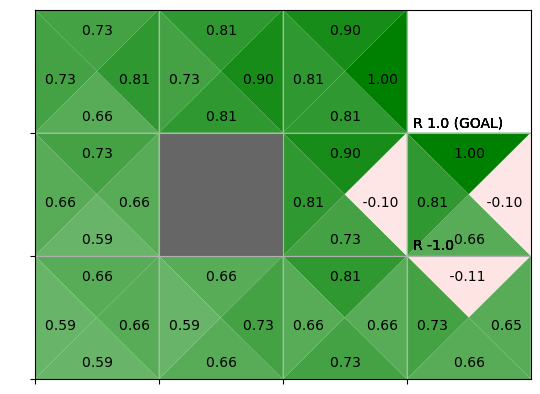

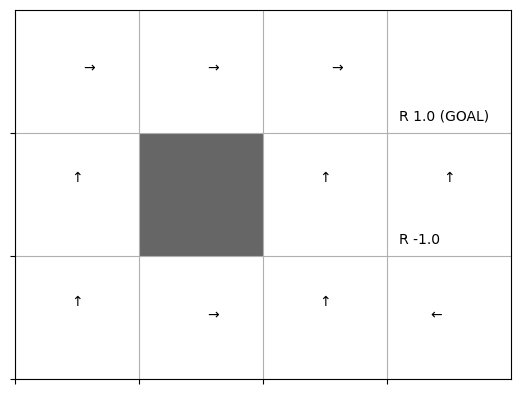

In [17]:
env = GridWorld()
agent = QLearningAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, next_state, done)
        if done:
            break
        state = next_state

env.render_q(agent.Q)

In [18]:
'''
ch06/q_learning_simple.py
'''
class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4
        self.Q = defaultdict(lambda: 0)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            qs = [self.Q[state, a] for a in range(self.action_size)]
            return np.argmax(qs)

    def update(self, state, action, reward, next_state, done):
        if done:
            next_q_max = 0
        else:
            next_qs = [self.Q[next_state, a] for a in range(self.action_size)]
            next_q_max = max(next_qs)

        target = reward + self.gamma * next_q_max
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha


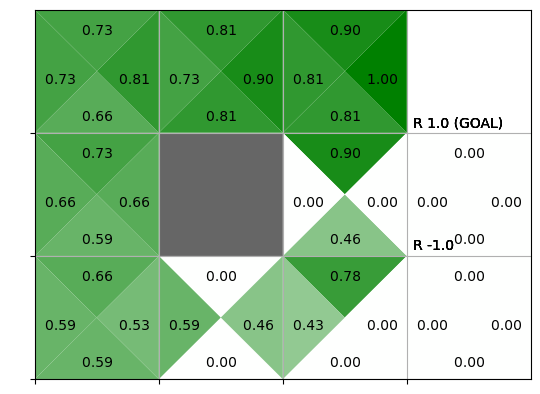

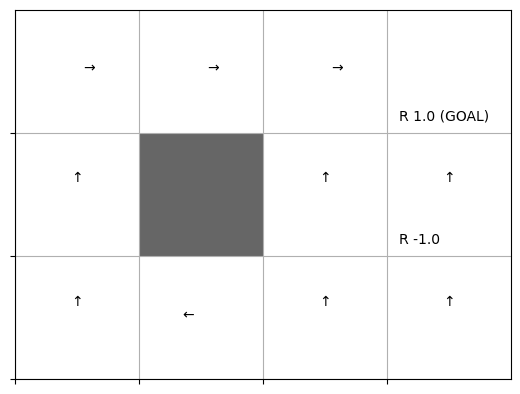

In [19]:
env = GridWorld()
agent = QLearningAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, next_state, done)
        if done:
            break
        state = next_state

env.render_q(agent.Q)

## 6.5 분포모델과 샘플모델

## 6.6 정리

- TD법은 (MC 법과 마찬가지로) 에 이 전 트 가 실제로 행 동 한 결과를 이용하여  가치 함수 를 평 가  
    -  ' 지금' 과 ' 다음' 의 정보만으로 가치함수 갱 신 (빠른 갱신으로 변동성 줄임)
    - 반면 mc법은 에이전트가 목표에 도달 해야만 가치 함수를 갱 신

- TD 법 알고리즘 두가지: SALSA / Q러닝 
    - SALSA : ( 일 반 적 으로) 온 - 정 책 방 식으로 $\epsilon$-탐욕화를 통해 정책개선 (탐색과 활용간 균형조정), 오 프 - 정 책 으로 확 장 가능.
    - Q러닝 : 벨만최적방정식 기 반으로 도출
        -  오프 - 정책 방식이지만 중요도샘플링을 사용하지 않으면서 Q 함수를 효율적/안정적으로 갱 신